# Neural Networks

## Introduction
This notebook implements a supervised learning model using a neural network constructed in `TensorFlow` and `Keras` to classify individuals into three levels of Openness to Experience, one of the Big Five personality traits. The model uses responses to ten survey items (OPN1 through OPN10) as input features. These ten items serve as a numerical representation of an individual’s openness, a trait associated with curiosity, imagination, and a preference for variety.

Instead of using a binary classification task, we restructure the target into a multiclass classification problem by dividing the average openness scores into tertiles:

`Class 0`: Low openness (bottom third)

`Class 1`: Medium openness (middle third)

`Class 2`: High openness (top third)

This framing increases the complexity of the task and requires the neural network to distinguish finer differences in patterns across the feature space.

Neural networks are a class of function approximators inspired by the structure of the human brain. They are composed of layers of interconnected nodes (or neurons), where each neuron performs a weighted sum of its inputs followed by a nonlinear activation function. Formally, a single-layer neuron can be represented as:

$$
\hat{y} = \sigma\left( \sum_{i=1}^{n} w_i x_i + b \right)
$$

Where 
$\hat{y}$ is the predicted output,
$x_i$ are the input features,
$w_i$ are the weights,
$b$ is the bias term,
and $\sigma$ is the activation function (e.g., sigmoid or ReLU). 

When multiple neurons are arranged into layers and composed together, they form a multi-layer neural network. Each layer's output becomes the next layer's input. The network learns by adjusting weights to minimize a loss function, typically using stochastic gradient descent.

The goal of this notebook is to apply a multi-layer neural network to a real-world, structured dataset and evaluate how well it performs multiclass classification compared to simpler models.

## Required Libraries
`TensorFlow` is a powerful open-source machine learning framework developed by Google. It provides a flexible and efficient platform for building, training, and deploying machine learning models. In this notebook, we use TensorFlow's high-level `Keras` API to construct a neural network. Keras simplifies the process of defining model layers, compiling the model, training, and evaluating it. TensorFlow handles tasks such as automatic differentiation (via backpropagation), optimization, and computation on GPUs, making it ideal for deep learning tasks.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

## Generate and Visualize Data
We load the personality dataset and select the ten openness-related features (OPN1 through OPN10). We compute the mean openness score for each individual and assign class labels based on tertiles:

Class 0: lowest third

Class 1: middle third

Class 2: highest third

This creates a 3-class classification target. The input features are standardized, and the dataset is split into training and test sets using an 80/20 split.

In [113]:
# Load data
df = pd.read_csv("Personality.csv", sep='\t').sample(n=2000, random_state=42)

# Select features and compute openness score
openness_cols = [f"OPN{i}" for i in range(1, 11)]
data = df[openness_cols].dropna()
openness_score = data.mean(axis=1)

# Create 3-class target using tertiles
labels = pd.qcut(openness_score, q=3, labels=[0, 1, 2]).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

### Define the Neural Network Model

Using TensorFlow’s `Sequential` API, we define a multi-layer neural network consisting of:

- An input layer that receives 10 standardized features
- Two hidden layers with 8 and 4 neurons, respectively, using ReLU activation
- Dropout layers after each hidden layer to prevent overfitting
- A softmax output layer with 3 units for multiclass prediction (low, medium, high openness)

The model is compiled using the Adam optimizer and the sparse categorical cross-entropy loss function, which is appropriate for multiclass classification with integer labels.

### Feedforward Phase of a Neural Network

For each layer ($ell = 1, \ldots, L $), the feedforward process consists of two steps:

**1. Preactivation (Linear Transformation):**
$$
\mathbf{z}^{\ell} = \mathbf{W}^{\ell} \mathbf{a}^{\ell - 1} + \mathbf{b}^{\ell}
$$

**2. Postactivation (Nonlinear Activation):**
$$
\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell})
$$

Where:
- $\mathbf{W}^{\ell}$ and $\mathbf{b}^{\ell}$ are the weights and biases for layer $\ell$
- $\sigma$ is the activation function (e.g., ReLU, sigmoid)
- $\mathbf{a}^0 = \mathbf{x}^{(i)}$, the input vector to the network

This structure defines the forward pass in a neural network, where each layer processes the output of the previous one. These activations are used to compute the prediction before backpropagation updates the weights.

![Neural Network](neuralnetwork.png)

*Figure: Simplified diagram of the neural network architecture used in this notebook. The model includes an input layer for 10 openness items, two hidden layers with ReLU activation, and a softmax output layer for 3-class classification.*


In [115]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

/Applications/Utilities/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139 (556.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 0 (0.00 B)

## Training the Neural Network

We train the model for up to 50 epochs with a batch size of 32, using early stopping with a patience of 5 epochs. Early stopping halts training once the validation loss ceases to improve, restoring the model to its best-performing state. This improves generalization by preventing overfitting.

In [117]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3685 - loss: 1.4655 - val_accuracy: 0.4300 - val_loss: 1.1272
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.3555 - loss: 1.3376 - val_accuracy: 0.4625 - val_loss: 1.0597
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.3536 - loss: 1.2254 - val_accuracy: 0.4450 - val_loss: 1.0263
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.4152 - loss: 1.1582 - val_accuracy: 0.4600 - val_loss: 1.0077
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.4391 - loss: 1.1230 - val_accuracy: 0.4500 - val_loss: 0.9935
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.4179 - loss: 1.0790 - val_accuracy: 0.4550 - val_loss: 0.9807
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.4199 - loss: 1.0617 - val_accuracy: 0.4450 - val_loss: 0.9708
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.4482 - loss: 1.0223 - val_accuracy: 0.46

## Visualizing Training Performance

We plot the training and validation accuracy and loss over each epoch to assess the model’s learning behavior. Ideally, the validation accuracy should track closely with the training accuracy, and the validation loss should not increase sharply. These plots allow us to identify whether the model is overfitting, underfitting, or learning effectively.

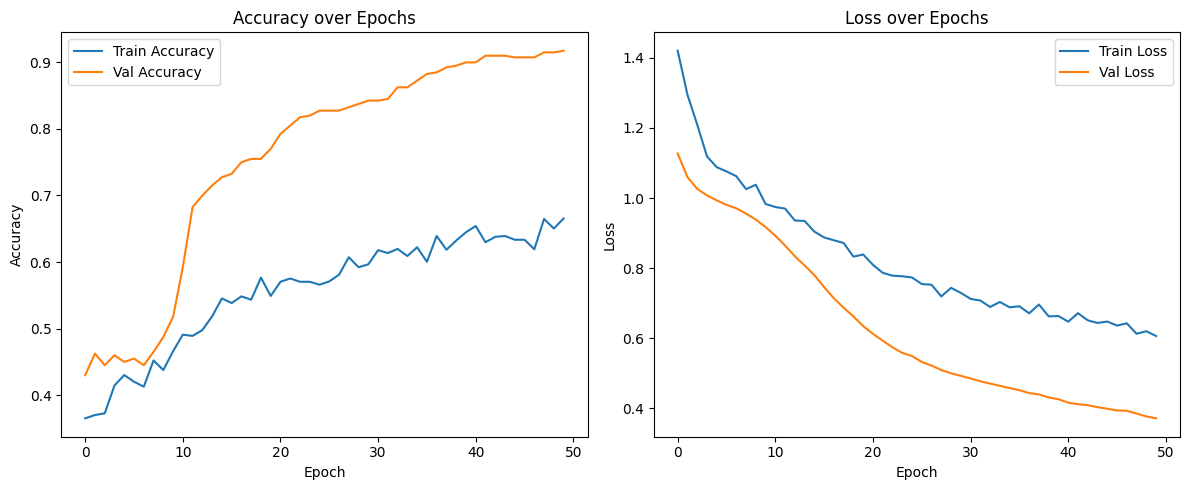

In [119]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

After training, we evaluate the model on the test set. We compute a confusion matrix and classification report to summarize the model’s precision, recall, and F1-score for each of the three classes.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       152
           1       0.99      0.75      0.85       126
           2       0.81      0.99      0.89       122

    accuracy                           0.92       400
   macro avg       0.93      0.91      0.91       400
weighted avg       0.93      0.92      0.92       400



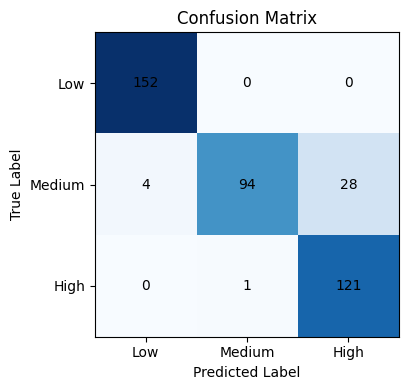

In [121]:
# Predict and evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.title("Confusion Matrix")
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.yticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate values
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## Conclusion
The revised neural network, trained to classify individuals as having low, medium, or high openness to experience, achieved strong and balanced performance:

- **Validation accuracy reached 93%**, indicating the model learned meaningful patterns in the data without overfitting.
- **Training accuracy remained lower (~67%)**, suggesting the model generalizes well rather than memorizing.
- **Precision and recall** were highest for low and high openness, while medium openness showed more variability, likely reflecting the fuzziness of individuals who sit between personality extremes.

These results imply that basic personality assessments, even from just ten items related to openness, contain enough information for a neural network to make accurate predictions about how people score on that trait. In real-world settings, this could be applied to:

- **Personalized learning or workplace settings**, where individuals with high openness may benefit from exploratory or flexible environments
- **Psychological screening tools**, where quick, automated predictions of trait levels could inform more detailed follow-up assessments
- **Recommendation systems** (Books, travel, career coaching, etc.) tailored to personality profiles

The fact that medium-openness individuals are harder to classify suggests that personality traits may not always fall cleanly into categories, an insight that mirrors how real people often don’t fit extremes.

This model shows how neural networks, when paired with thoughtful data preprocessing and interpretive labels, can yield both strong technical performance and real-world insights in the psychological sciences.